This project I have selected Ebay to scrapper and gather data.

--------
## Step - 1
Scrapping

In [ ]:
import csv
import re
import urllib.parse
import urllib.request
from threading import Thread

from bs4 import BeautifulSoup


class EbayScraper:
    def __init__(self):
        self.ebay_urls = {
            "au": ".com.au",
            "at": ".at",
            "be": ".be",
            "ca": ".ca",
            "ch": ".ch",
            "de": ".de",
            "es": ".es",
            "fr": ".fr",
            "hk": ".com.hk",
            "ie": ".ie",
            "it": ".it",
            "my": ".com.my",
            "nl": ".nl",
            "ph": ".ph",
            "pl": ".pl",
            "sg": ".com.sg",
            "uk": ".co.uk",
            "us": ".com",
        }
        self.condition_flags = {
            "all": "",
            "new": "&LH_ItemCondition=1000",
            "opened": "&LH_ItemCondition=1500",
            "refurbished": "&LH_ItemCondition=2500",
            "used": "&LH_ItemCondition=3000",
        }
        self.listing_types = {
            "all": "&LH_All=1",
            "auction": "&LH_Auction=1",
            "bin": "&LH_BIN=1",
            "offers": "&LH_BO=1",
        }
        self.data = []

    def scrape_listings(
        self, product_name, country_code="ca", condition="new", listing_type="offers"
    ):
        if country_code not in self.ebay_urls:
            raise ValueError(f"Unsupported country code: {country_code}")

        url = self._build_url(product_name, country_code, condition, listing_type)
        soup = self._fetch_page(url)
        listings = self._parse_listings(soup)
        return listings

    def _build_url(self, query, country, condition, listing_type):
        base_url = f"https://www.ebay{self.ebay_urls[country]}/sch/i.html"
        query = urllib.parse.quote(query.replace(" ", "+"))
        condition_query = self.condition_flags.get(condition, "")
        listing_type_query = self.listing_types.get(listing_type, "")
        return f"{base_url}?_from=R40&_nkw={query}{condition_query}{listing_type_query}&LH_Complete=1&LH_Sold=1"

    def _fetch_page(self, url):
        response = urllib.request.urlopen(url)
        return BeautifulSoup(response.read(), "html.parser")

    def _parse_listings(self, soup):
        listings = soup.find_all("div", {"class": "s-item__info clearfix"})
        detailed_data = []

        for listing in listings:
            title_element = listing.find(class_="s-item__title")
            price_element = listing.find("span", {"class": "s-item__price"})
            shipping_element = listing.find(
                "span", {"class": "s-item__shipping s-item__logisticsCost"}
            )
            bid_count_element = listing.find(class_="s-item__bids s-item__bidCount")
            url_element = listing.find("a", {"class": "s-item__link"})

            title = title_element.text.strip() if title_element else "No Title"
            price = (
                self._parse_price(price_element.text.strip()) if price_element else 0.0
            )
            shipping = (
                self._parse_shipping(shipping_element.text.strip())
                if shipping_element
                else "Unknown"
            )
            bid_count = (
                int(bid_count_element.text.strip().split(" ")[0])
                if bid_count_element
                else 0
            )
            url = url_element["href"] if url_element else "No URL"

            detailed_data.append(
                {
                    "title": title,
                    "price": price,
                    "shipping": shipping,
                    "bid_count": bid_count,
                    "url": url,
                }
            )

        return detailed_data

    def _parse_price(self, price_text):
        price = re.search(r"(\d+(\.\d+)?)", price_text.replace(",", "."))
        return float(price.group()) if price else 0.0

    def save_to_csv(self, filename="ebay_data.csv"):
        with open(filename, "w", newline="") as file:
            writer = csv.DictWriter(file, fieldnames=self.data[0].keys())
            writer.writeheader()
            writer.writerows(self.data)


if __name__ == "__main__":
    scraper = EbayScraper()
    product_names = [
        'vitamins and dietary supplements'
        'skincare products',
        'perfume',
        'hair straighteners',
        'hair dryers',
        'Electronics',
        'cables',
        'computers',
        'mobile accessories',
        'Toys',
        'Apple',
        'scanners',
        'Shoes',
        'Adidas',
        'Nike',
        'furniture',
        'Afghans',
        'Throw Blankets',
        'Afghans and Throw Blankets',
        'Pet Supplies',
        'Bookends',
        'Jewelry',
        'Watches',
        'Necklaces',
        'Pendants',
        'Wristwatch Bands',
        'Wristwatches',
        'sports memorabilia',
        'Historical Artifacts',
        'Automotive Parts',
        'Fashion',
        'Motors',
        'Collectibles',
        'Musical Instruments and Gear',
        'Motors',
    ]
    for product in product_names:
        scraper.scrape_listings(product)
    scraper.save_to_csv()

-----
## Step - 2 Cleaning

In [1]:
#Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.metrics import pairwise_distances
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold

# Import necessary libraries
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [2]:
# Read the CSV file into a DataFrame
df = pd.read_csv('Ebay_Products.csv')

In [3]:
df.head(2)

,item_approx_price,Accurate description,price,time_left,seller_name,Communication,time_end,Shipping speed,title,shipping,bid_count,feedback_pr,item_primary_price,review_count,Reasonable shipping cost,item_no,comment
0,0,4.9,2.09,NaN,pearlwholesale,4.9,NaN,4.9,Fashion Silver Zircon Christmas Xmas Elk Earri...,0.00,0,98.4%Positive Feedback,2.09,0,5,2.350000e+11,Perfect fit! Arrived early than expected!&Perf...
1,118.22,4.6,118.22,NaN,mdzahed99,4.6,NaN,5,Brand New In Box Emporio Armani AR2448 Blue Di...,21.77,0,93.5%Positive Feedback,86.55,0,5,1.850000e+11,NaN


In [4]:
df.shape  

(4680, 17)

In [5]:
df.columns # Dataset columns 

Index(['item_approx_price', 'Accurate description', 'price', 'time_left',
       'seller_name', 'Communication', 'time_end', 'Shipping speed', 'title',
       'shipping', 'bid_count', 'feedback_pr', 'item_primary_price',
       'review_count', 'Reasonable shipping cost', 'item_no', 'comment'],
      dtype='object')

In [6]:
df.drop(columns=['time_left', 'time_end', 'price', 'shipping', 'bid_count'], inplace=True) # Drop unnecessary columns 
df.rename(columns={'Accurate description': 'accurate_description', 'Communication': 'communication','Shipping speed': 'shipping_speed', 
                   'Reasonable shipping cost': 'reasonable_shipping_cost'}, inplace=True) # Rename columns

In [7]:
df['feedback_pr'] = df['feedback_pr'].str.extract('(\d+\.\d+)', expand=False).fillna(0) # Extract numeric values and fill NaN with 0

In [8]:
# display non-convertible float values  
display_non_convertible_float_values = lambda col, df: print(f"Non-convertible values in {col}: {[value for value in df[col] if not str(value).replace('.', '').isdigit()]}")

In [9]:
def non_convertible_flt_values(column, df): 
    non_float_values = {val for val in df[column] if not is_floatable(val)}
    
    # Return the results as a sorted list for consistency
    return sorted(list(non_float_values))

def is_floatable(value):
    try:
        float(value)
        return True
    except (ValueError, TypeError):
        return False

In [32]:
float_columns = ['accurate_description', 'communication', 'shipping_speed', 'reasonable_shipping_cost', 'item_primary_price', 
                 'item_approx_price', 'feedback_pr']
columns_to_check = ['item_primary_price', 'item_approx_price', 'feedback_pr']

#  Non-convertible values
for col in float_columns:
    print(f" Weird Values in {col} ".center(50, '-'))
    print(f"Non-Convertible Values: {non_convertible_flt_values(col, df)}")

------ Weird Values in accurate_description ------
Non-Convertible Values: []
--------- Weird Values in communication ----------
Non-Convertible Values: []
--------- Weird Values in shipping_speed ---------
Non-Convertible Values: []
---- Weird Values in reasonable_shipping_cost ----
Non-Convertible Values: []
------- Weird Values in item_primary_price -------
Non-Convertible Values: []
------- Weird Values in item_approx_price --------
Non-Convertible Values: []
---------- Weird Values in feedback_pr -----------
Non-Convertible Values: []


In [12]:
# Lambda function to remove separators and convert to float
remove_thousand_separator_and_convert_to_float = lambda value: float(str(value).replace(',', '')) if pd.notna(value) else 0

In [13]:
# Function to remove separators and convert to float
def remove_thousand_separator(value):
    value_str = str(value).strip().lower()
    if value_str == 'nan':
        return 0.0

    # Attempt to correct the format and convert to float
    try:
        # Correct the format if it appears to be split incorrectly by thousand separators
        corrected_value = value_str.replace(',', '').replace(' ', '')
        return float(corrected_value)
    except ValueError:
        # Return 0 for any value that cannot be converted to float
        return 0.0
for col in float_columns:      # Remove separators and convert to float  
    df[col] = df[col].apply(remove_thousand_separator)

In [14]:
print(df.dtypes) # Data types
print(df.isna().sum()) #check for missing values
df.dropna(inplace=True)

item_approx_price           float64
accurate_description        float64
seller_name                  object
communication               float64
shipping_speed              float64
title                        object
feedback_pr                 float64
item_primary_price          float64
review_count                  int64
reasonable_shipping_cost    float64
item_no                     float64
comment                      object
dtype: object
item_approx_price              0
accurate_description           0
seller_name                   37
communication                  0
shipping_speed                 0
title                          0
feedback_pr                    0
item_primary_price             0
review_count                   0
reasonable_shipping_cost       0
item_no                        0
comment                     2793
dtype: int64


-----
## Step - 3 Visualization to demonstrate the distribution of various columns

C:\Users\14374\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


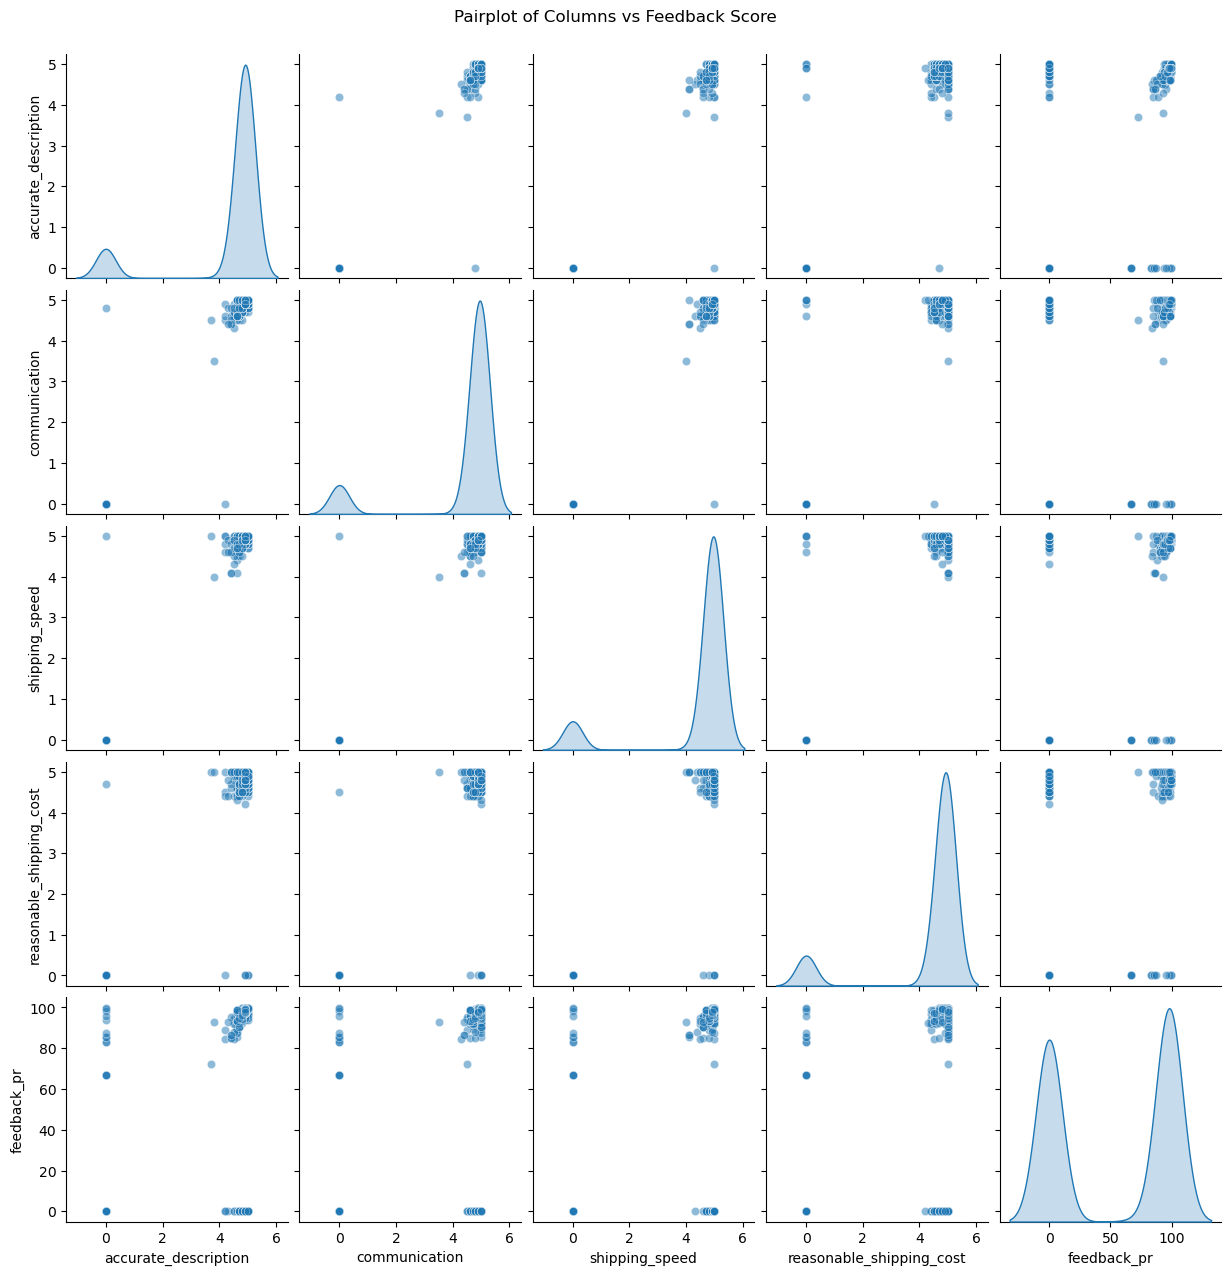

In [16]:
import seaborn as sns

# Select the columns of interest
columns = ['accurate_description', 'communication', 'shipping_speed', 'reasonable_shipping_cost', 'feedback_pr']

# Create a pairplot
sns.pairplot(df[columns], diag_kind='kde', plot_kws={'alpha': 0.5})
plt.suptitle('Pairplot of Columns vs Feedback Score', y=1.02)
plt.show()

-----
## Step - 4 pandas profiling 

In [17]:
# installing ydata-profiling library to generate report
!pip install ydata-profiling

  Obtaining dependency information for ydata-profiling from https://files.pythonhosted.org/packages/04/45/647c0ebe33584476c335d789a55005683cfa640e07796266de8557560850/ydata_profiling-4.6.5-py2.py3-none-any.whl.metadata
  Obtaining dependency information for pydantic>=2 from https://files.pythonhosted.org/packages/e5/f3/8296f550276194a58c5500d55b19a27ae0a5a3a51ffef66710c58544b32d/pydantic-2.6.4-py3-none-any.whl.metadata
     ---------------------------------------- 0.0/85.1 kB ? eta -:--:--
     ------------- ------------------------ 30.7/85.1 kB 660.6 kB/s eta 0:00:01
     ---------------------------------------- 85.1/85.1 kB 1.2 MB/s eta 0:00:00
  Obtaining dependency information for visions[type_image_path]==0.7.5 from https://files.pythonhosted.org/packages/62/fa/6a8539c83d2ccbd08d5f0c843b1784af9ff514e77f4c9d5d6800fdd340f6/visions-0.7.5-py3-none-any.whl.metadata
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Obtaining dependen

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
anaconda-cloud-auth 0.1.3 requires pydantic<2.0, but you have pydantic 2.6.4 which is incompatible.


In [18]:
from ydata_profiling import ProfileReport

# Generate the data profiling report 
report = ProfileReport(df, title='Ebay_Data')

# Save the report to an HTML file
report.to_file("pandas_profiling_report.html")

C:\Users\14374\anaconda3\Lib\site-packages\ydata_profiling\profile_report.py:354: UserWarning: Try running command: 'pip install --upgrade Pillow' to avoid ValueError
  warnings.warn(


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

-------
## Step 5 Encoding: One-Hot Encoding

In [19]:
# One-Hot Encoding on categorical columns
df_encoded = pd.get_dummies(df, columns=['seller_name'])

In [20]:
import re

# Cleans the comments in the 'comment' column by removing special characters and emojis. 
df['comment'] = df['comment'].apply(lambda x: re.sub(r'[^&\w\s,]', '', x) if pd.notna(x) else '')

# Display cleaned comments and no of columns
df.head()

,item_approx_price,accurate_description,seller_name,communication,shipping_speed,title,feedback_pr,item_primary_price,review_count,reasonable_shipping_cost,item_no,comment
0,0.00,4.9,pearlwholesale,4.9,4.9,Fashion Silver Zircon Christmas Xmas Elk Earri...,98.4,2.09,0,5.0,2.350000e+11,Perfect fit Arrived early than expected&Perfec...
3,190.66,4.9,dragonemad,5.0,5.0,Carly Universal Scanner BMW Diagnostic Best Ap...,0.0,139.85,26,4.9,1.240000e+11,Awesome I found things I didnt even know my ca...
6,15.90,4.7,Seven Star Solutions,4.8,4.8,"Aqua Red Perfume For Men, Long Lasting & Smoot...",0.0,11.66,0,5.0,3.750000e+11,"Good seller, otem as described and packed well..."
7,20.45,4.9,adalyn1973,5.0,5.0,"Alfred's Basic Piano Library lot of 3 Lesson, ...",0.0,15.00,0,4.9,3.860000e+11,Exactly as statedgreat vintage style Carolina ...
8,4.09,4.2,ray_6049,0.0,5.0,"PetSpy N10 Ultrasonic Dog Bark Deterrent, 2 Fr...",84.6,3.00,0,4.5,1.260000e+11,Rackety quack&Rackety quack&Missing critical c...


----
## Step 6 Identify Outliers with different technique

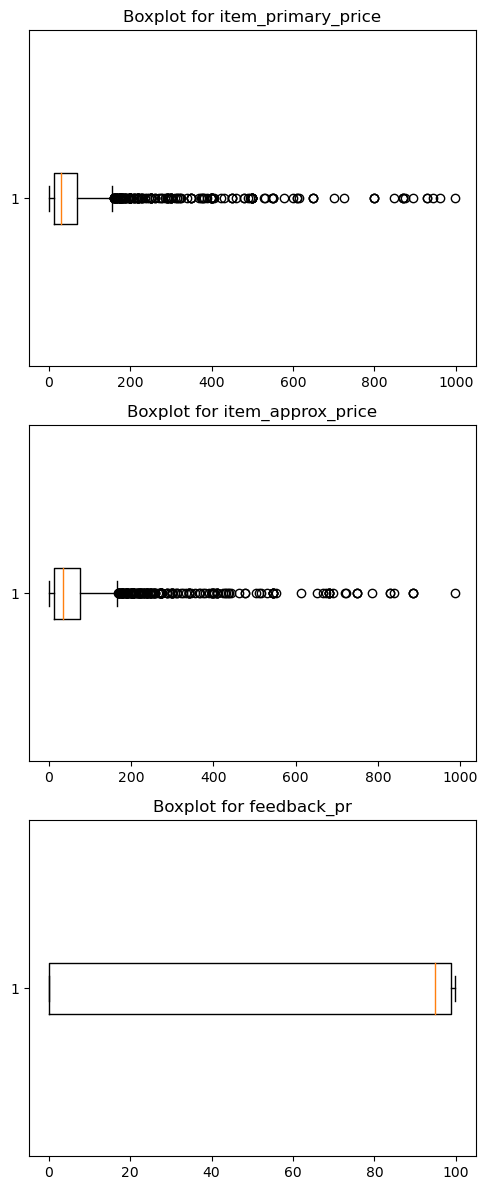

Outliers in item_primary_price: 63
Outliers in item_approx_price: 36
Outliers in feedback_pr: 0


In [21]:
import matplotlib.pyplot as plt

# Set up the plotting environment
fig, axes = plt.subplots(nrows=len(columns_to_check), figsize=(5, 4 * len(columns_to_check)))

# 1. Plot boxplots 
for i, column in enumerate(columns_to_check):
    ax = axes[i] if len(columns_to_check) > 1 else axes  # If there's only one column, axes is not a list
    ax.boxplot(df[column], vert=False) # Plot the boxplot horizontally
    ax.set_title(f'Boxplot for {column}') # Set title for boxplot

# Plot Boxplot
plt.tight_layout()
plt.show()

# 2. Identify outliers using IQR
for column in columns_to_check:
    q1 = df[column].quantile(0.10)
    q3 = df[column].quantile(0.90)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    print(f'Outliers in {column}: {outliers[column].count()}') # Print number of outliers


-----
## Step 7 Handle outliers with 3 different techniques:
1. Quantile-based Flooring and Capping
2. Trimming
3. Log Transformation

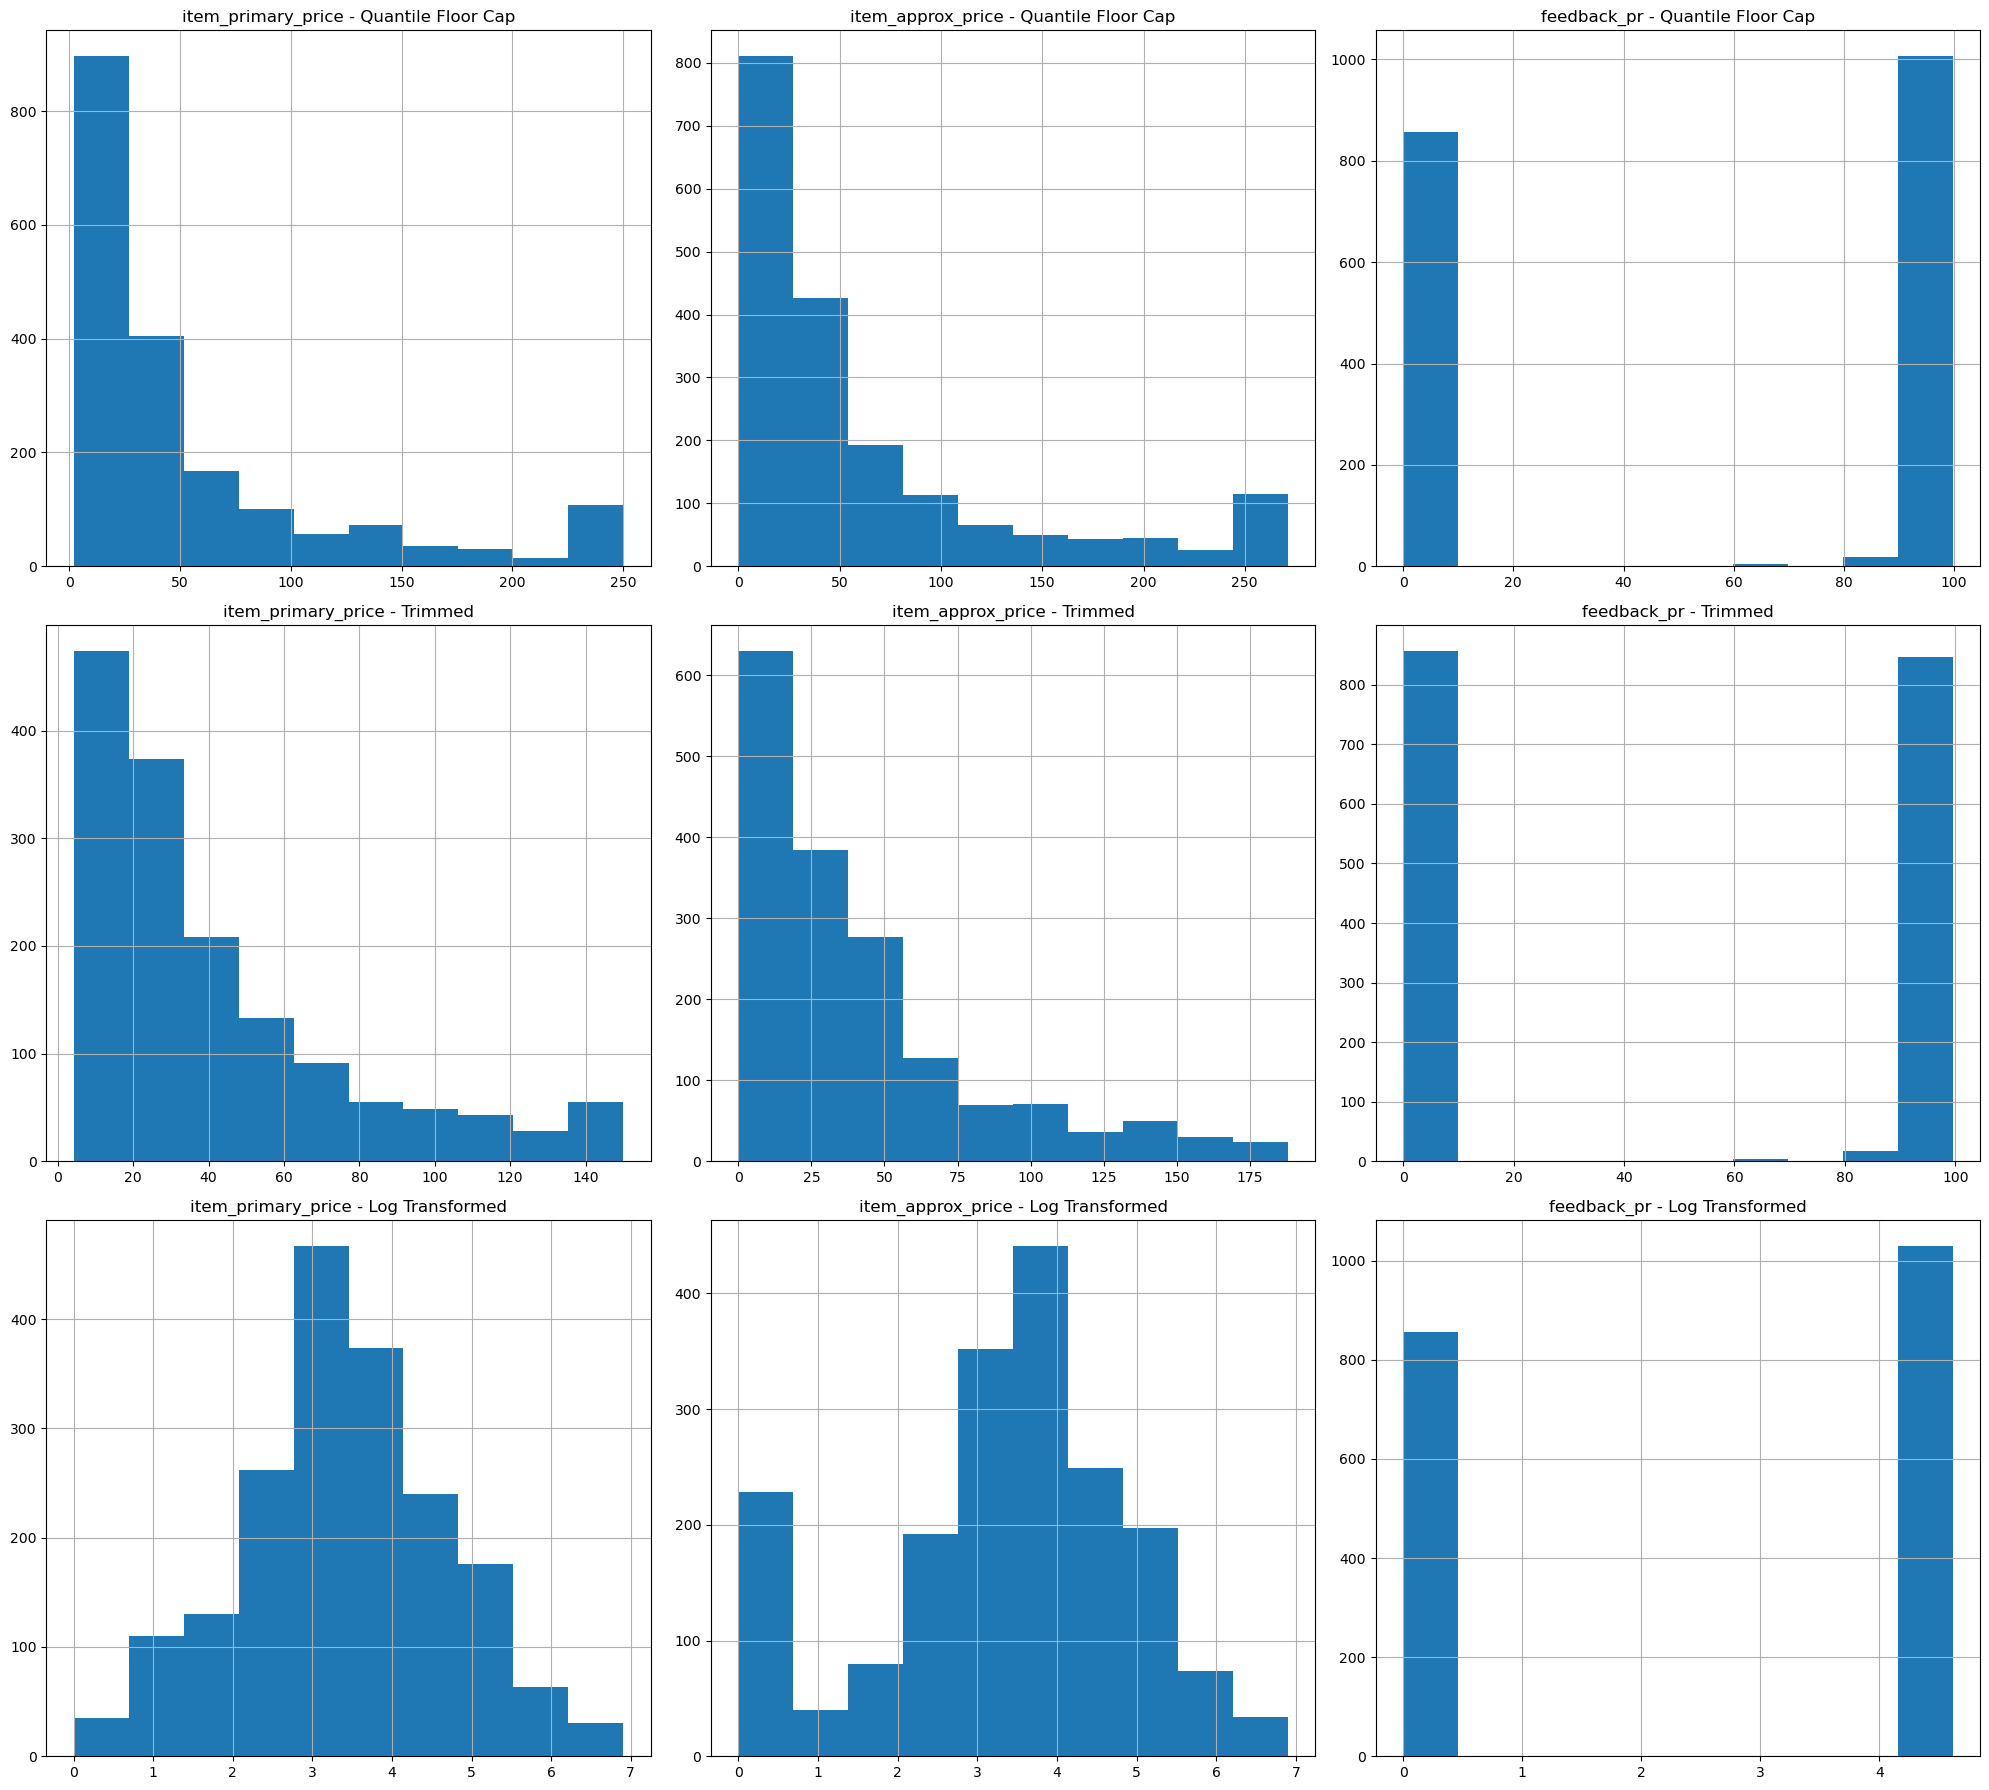

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. Quantile-based Flooring and Capping function
quantile_floor_cap = lambda series, lower_percentile=0.05, upper_percentile=0.95: \
    series.clip(lower=series.quantile(lower_percentile), upper=series.quantile(upper_percentile))

# 2. Trimming function
trim_data = lambda series, trim_value=0.1: \
    series[(series >= series.quantile(trim_value)) & (series <= series.quantile(1 - trim_value))]

# 3. Log Transformation function
log_transform = lambda series: np.log1p(series)

# Store results in the new DataFrame
transformed_df = pd.DataFrame({f'{column}_quantile_floor_cap': quantile_floor_cap(df[column]),
                               f'{column}_trimmed': trim_data(df[column]),
                               f'{column}_log_transformed': log_transform(df[column])
                               } for column in columns_to_check)

# Plot the results
fig, axes = plt.subplots(nrows=3, ncols=len(columns_to_check), figsize=(20, 18))
for i, column in enumerate(columns_to_check):
    transformed_df[f'{column}_quantile_floor_cap'].hist(ax=axes[0, i])
    axes[0, i].set_title(f'{column} - Quantile Floor Cap')

    transformed_df[f'{column}_trimmed'].hist(ax=axes[1, i])
    axes[1, i].set_title(f'{column} - Trimmed')

    transformed_df[f'{column}_log_transformed'].hist(ax=axes[2, i])
    axes[2, i].set_title(f'{column} - Log Transformed')
    
plt.tight_layout()
plt.show()


In [23]:
for column in columns_to_check:
    df[column] = log_transform(df[column])

----
## Step 8 Unsupervised Learning Methods:

#### 1. Gaussian Mixture Model (GMM)

In [25]:
from sklearn.mixture import GaussianMixture
feature_cols = ['accurate_description', 'communication', 'shipping_speed', 'reasonable_shipping_cost', 'item_primary_price', 'item_approx_price', 'feedback_pr']

gmm = GaussianMixture(n_components=3, random_state=42) # Initialize GMM 
gmm.fit(df[feature_cols]) # Fit GMM to the data
labels = gmm.predict(df[feature_cols]) # predicted labels 
df['gmm_score'] = labels #score based on the predicted labels
selected_features = df.groupby('gmm_score')[feature_cols].mean().idxmax() # Sort the features based on the GMM scores

print("Selected Features:", selected_features) # Print selected features 


Selected Features: accurate_description        2
communication               2
shipping_speed              2
reasonable_shipping_cost    0
item_primary_price          1
item_approx_price           2
feedback_pr                 0
dtype: int64


C:\Users\14374\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(


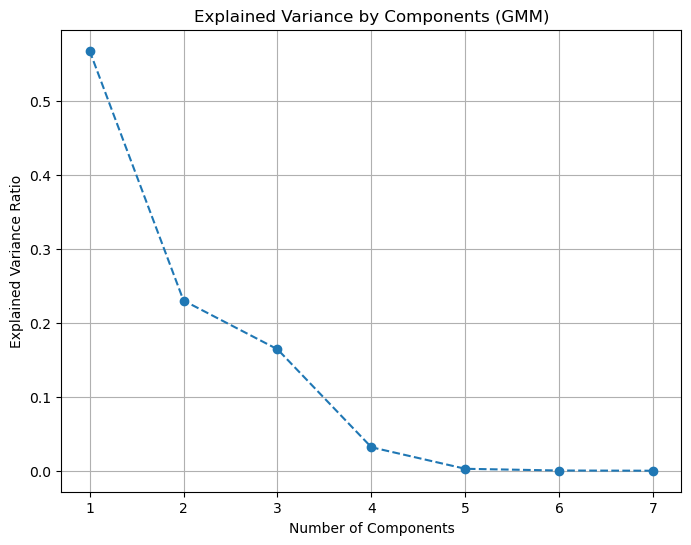

In [26]:
# Plot the explained variance ratios
pca = PCA(n_components=len(feature_cols))
pca.fit(df[feature_cols])

# Get the explained variance ratios
explained_variance = pca.explained_variance_ratio_


plt.figure(figsize=(8, 6))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--')
plt.title('Explained Variance by Components (GMM)')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.grid()
plt.show()

#### 2. K-Means Clustering 

In [27]:

# Scale the data using StandardScaler
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df[feature_cols])

C:\Users\14374\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\14374\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(


kmeans_cluster
2    1006
0     663
1     218
Name: count, dtype: int64


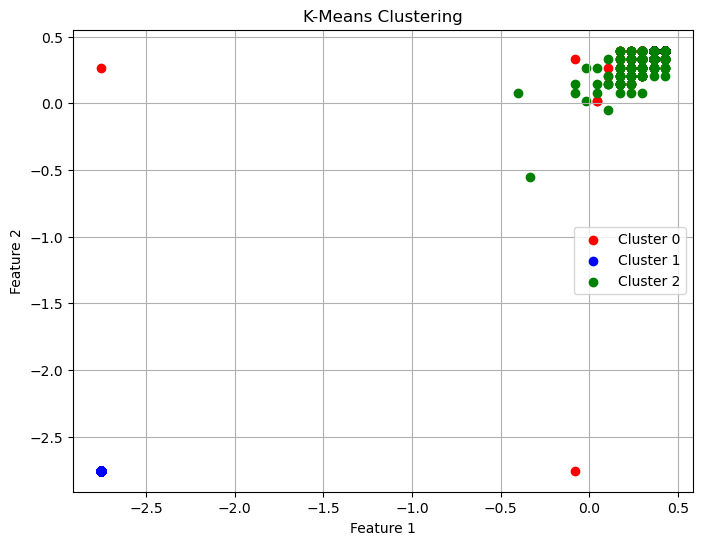

Silhouette Score for K-Means Clustering: 0.40201718091213734


In [33]:

# KMeans with the desired number of clusters
kmeans = KMeans(n_clusters=3, random_state=42)
df['kmeans_cluster'] = kmeans.fit_predict(scaled_data)

print(df['kmeans_cluster'].value_counts()) # Results
kmeans_colors = ['red', 'blue', 'green'] # Assign colors for the clusters

# Plot the clusters
plt.figure(figsize=(8, 6))
for i in range(3):  # 3 clusters in K-Means Clustering
    plt.scatter(scaled_data[df.kmeans_cluster == i, 0], scaled_data[df.kmeans_cluster == i, 1], color=kmeans_colors[i], label=f'Cluster {i}')
plt.title('K-Means Clustering')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True)
plt.show()

from sklearn.metrics import silhouette_score
# Calculate the Silhouette Score
silhouette_score_kmeans = silhouette_score(scaled_data, df['kmeans_cluster'])
print(f"Silhouette Score for K-Means Clustering: {silhouette_score_kmeans}")


## Step - 9 NLP techniques  

In [30]:
# Function to clean and preprocess text data
def text_cleaning(comment):
    tokens = word_tokenize(comment.lower())
    filtered_tokens = [token for token in tokens if token not in stopwords.words('english')]
    lemmatized_tokens = [WordNetLemmatizer().lemmatize(token) for token in filtered_tokens]
    return ' '.join(lemmatized_tokens)

# Perform sentiment analysis using VADER
def sentiment_analysis(comments):
    analyzer = SentimentIntensityAnalyzer()
    return [analyzer.polarity_scores(text_cleaning(comment)) for comment in comments.split('&')]

# Calculate sentiment scores for each seller
df['sentiment_scores'] = df['comment'].apply(sentiment_analysis)

# Flatten sentiment scores and create a DataFrame
analyze_df = pd.DataFrame(df['sentiment_scores'].sum())

# Calculate overall sentiment score
analyze_df['score'] = analyze_df['pos'] - analyze_df['neg']


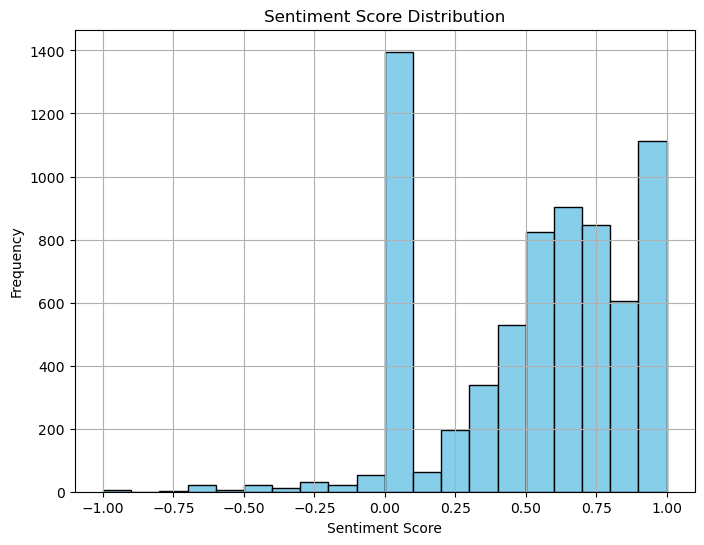

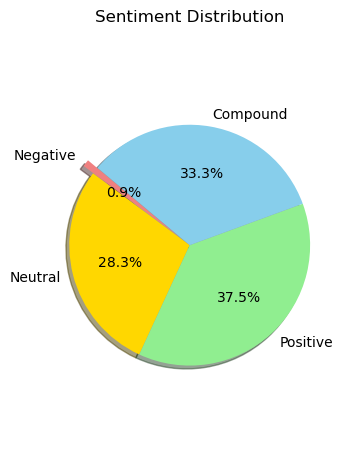

In [31]:

# Plot sentiment score distribution
plt.figure(figsize=(8, 6))
plt.hist(analyze_df['score'], bins=20, color='skyblue', edgecolor='black')
plt.title('Sentiment Score Distribution')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Plot sentiment distribution using pie chart
plt.subplot(1, 2, 2)
labels = ['Negative', 'Neutral', 'Positive', 'Compound']
sizes = [analyze_df['neg'].mean(), analyze_df['neu'].mean(), analyze_df['pos'].mean(), analyze_df['compound'].mean()]
colors = ['lightcoral', 'gold', 'lightgreen', 'skyblue']
explode = (0.1, 0, 0, 0)  # Explode the 1st slice
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Sentiment Distribution')

plt.tight_layout()
plt.show()

# Thank You!!!